# Taller de repaso: Aprendizaje no supervisado - parte 2

## Preparación del notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
#!pip install kneed
from kneed import KneeLocator

from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA, FactorAnalysis

#!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer

#!pip install plotly
import plotly.express as px

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Lectura del dataset

In [5]:
# Lectura del dataset
df = pd.read_csv('https://raw.githubusercontent.com/mlondono-oc/LEA2/main/Modulo-3/data/train.csv')
df.head(3)

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied


## Pre-procesamiento

In [6]:
# Eliminación de variables no significativas
df.drop(['Unnamed: 0', 'id', 'Arrival Delay in Minutes'], axis=1, inplace=True)
# Tomas una muestra aleatoria
df_sample = df.sample(n=2500, random_state=123)
df_sample.reset_index(drop=True, inplace=True)

# Codificación de variable satisfacción
train_df1 = df_sample.copy()
train_df1['satisfaction'] = train_df1['satisfaction'].map({'neutral or dissatisfied':0, 'satisfied':1})
train_df1['Gender'] = train_df1['Gender'].map({'Female':0, 'Male':1})
train_df1['Customer Type'] = train_df1['Customer Type'].map({'disloyal Customer':0, 'Loyal Customer':1})
train_df1['Type of Travel'] = train_df1['Type of Travel'].map({'Personal Travel':0, 'Business travel':1})
train_df1['Class'] = train_df1['Class'].map({'Eco':1, 'Eco Plus':2, 'Business':3})

# Escalado de variables numéricas
train_cols = train_df1[['Age', 'Flight Distance', 'Departure Delay in Minutes']]
scaler = StandardScaler()
scaled_train_df1 = pd.DataFrame(scaler.fit_transform(train_cols), columns = train_cols.columns)

#  Union de data numéricas  y categórica
cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes']
train_df1[cols] = scaled_train_df1

# Tratamiento de valores atípicos
train_df1_out = train_df1.copy()
# Identificación de valores atípicos
media = train_df1_out.mean()
std = train_df1_out.std()
lim_superior = media + 3 * std
lim_inferior = media - 3 * std
outliers = train_df1_out[(train_df1_out > lim_superior)|(train_df1_out < lim_inferior)].stack()
train_df1_out = train_df1_out.drop(outliers.index.get_level_values(0))
train_df1_out.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction
0,0,1,0.428280,1,3,1.712718,2,2,2,2,...,4,4,4,4,4,5,4,3,-0.146356,1
1,1,1,0.362354,1,3,-0.806434,2,1,1,1,...,3,2,2,2,2,2,2,4,-0.394517,0
2,0,1,-0.626532,0,1,-0.864560,2,2,2,4,...,2,2,4,2,3,3,4,2,-0.394517,0


## Reducción de la dimensionalidad

In [7]:
#Cree un dataset reducido solo a 3 componentes
pca = PCA(n_components=3).fit(train_df1_out)

#Por último, transforme "train_df1"
X_pca = pca.fit_transform(train_df1_out)
X_pca[:3]

array([[-1.99648466,  2.32438215,  0.41384258],
       [ 2.39786993,  2.50755665, -2.78032545],
       [ 3.25932848, -0.15142549,  0.95156292]])

In [8]:
df_final = train_df1_out.copy()
df_final['PCA1'] = X_pca[:,0]
df_final['PCA2'] = X_pca[:,1]
df_final['PCA3'] = X_pca[:,2]
df_final.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction,PCA1,PCA2,PCA3
0,0,1,0.428280,1,3,1.712718,2,2,2,2,...,4,4,5,4,3,-0.146356,1,-1.996485,2.324382,0.413843
1,1,1,0.362354,1,3,-0.806434,2,1,1,1,...,2,2,2,2,4,-0.394517,0,2.397870,2.507557,-2.780325
2,0,1,-0.626532,0,1,-0.864560,2,2,2,4,...,2,3,3,4,2,-0.394517,0,3.259328,-0.151425,0.951563


Las loadings o cargas pueden interpretarse como el peso/importancia que tiene cada variable en cada componente y, por lo tanto, ayudan a conocer que tipo de información recoge cada una de las componentes.

In [9]:
# --- Pesos de las variables que componen las componentes principales ---
pesos_pca = pd.DataFrame(pca.components_, columns = train_df1_out.columns,
             index = ['PC 1', 'PC 2', 'PC 3']).round(2).T

pesos_pca

,PC 1,PC 2,PC 3
Gender,-0.00,0.00,0.01
Customer Type,-0.03,-0.01,-0.01
Age,-0.06,-0.00,-0.06
Type of Travel,-0.03,0.03,-0.01
Class,-0.14,0.05,0.07
Flight Distance,-0.10,0.04,0.02
Inflight wifi service,-0.25,-0.39,-0.03
Departure/Arrival time convenient,-0.14,-0.52,0.02
Ease of Online booking,-0.21,-0.51,-0.05
Gate location,-0.07,-0.40,-0.08


## Modelo K-means

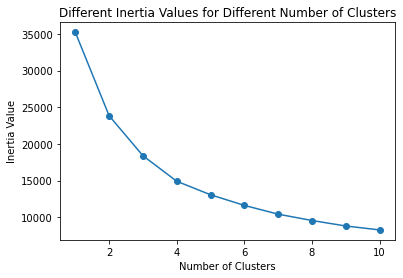

In [10]:
# Número optimo de K
inertia_list = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=3)
    kmeans.fit(X_pca)
    inertia_list.append(kmeans.inertia_)

# plot the inertia curve
plt.plot(range(1,11),inertia_list)
plt.scatter(range(1,11),inertia_list)
plt.xlabel("Number of Clusters", size=10)
plt.ylabel("Inertia Value", size=10)
plt.title("Different Inertia Values for Different Number of Clusters", size=12)
plt.show()

In [11]:
kmeans_constants = {"init": "k-means++", "n_init": 100, "max_iter": 500, "random_state": 42}

# --- Modelo K-means ---
model_kmeans = KMeans(n_clusters = 4, **kmeans_constants)
model_kmeans.fit(X_pca)

KMeans(max_iter=500, n_clusters=4, n_init=100, random_state=42)

In [12]:
# --- Evaluación del modelo kmeans ---
print(" ### K-MEANS ###")
print('Inertia: ', model_kmeans.inertia_)
print('Silhouette Score: ', silhouette_score(X_pca, model_kmeans.labels_))
print('Calinski harabasz score: ', calinski_harabasz_score(X_pca, model_kmeans.labels_))

 ### K-MEANS ###
Inertia:  14908.887602543973
Silhouette Score:  0.28767670278972834
Calinski harabasz score:  1105.6930971835159


In [13]:
# Predicción de los clusters
Cluster_1 = model_kmeans.fit_predict(X_pca)

df_final['Cluster_1']= Cluster_1

# A partir de ahora, sólo trabajaremos con "df_final"
df_final.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction,PCA1,PCA2,PCA3,Cluster_1
0,0,1,0.428280,1,3,1.712718,2,2,2,2,...,4,5,4,3,-0.146356,1,-1.996485,2.324382,0.413843,2
1,1,1,0.362354,1,3,-0.806434,2,1,1,1,...,2,2,2,4,-0.394517,0,2.397870,2.507557,-2.780325,0
2,0,1,-0.626532,0,1,-0.864560,2,2,2,4,...,3,3,4,2,-0.394517,0,3.259328,-0.151425,0.951563,1


In [15]:
# 3d scatterplot using plotly.express
df_final['Cluster_1'] = df_final['Cluster_1'].astype('category')
fig = px.scatter_3d(df_final, x="PCA1", y="PCA2", z="PCA3", color="Cluster_1")
fig.update_layout(width=1000, height=700)
fig.show()

In [18]:
fig = px.scatter(df_final, x="PCA2", y="PCA3", color="Cluster_1")
fig.update_layout(width=1000, height=700)
fig.show(config={'displayModeBar': False})

## Interpretación clusters

In [19]:
# Conversión de variables numéricas a valores originales
train_cols = train_df1_out[['Age', 'Flight Distance', 'Departure Delay in Minutes']]
scaled_train_df1 = pd.DataFrame(scaler.inverse_transform(train_cols), columns = train_cols.columns)

# Union de data numéricas y categórica
cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes']
df_final[cols] = scaled_train_df1
df_final.head(3)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction,PCA1,PCA2,PCA3,Cluster_1
0,0,1,46.0,1,3,2954.0,2,2,2,2,...,4,5,4,3,1.000000e+01,1,-1.996485,2.324382,0.413843,2
1,1,1,45.0,1,3,397.0,2,1,1,1,...,2,2,2,4,1.776357e-15,0,2.397870,2.507557,-2.780325,0
2,0,1,30.0,0,1,338.0,2,2,2,4,...,3,3,4,2,1.776357e-15,0,3.259328,-0.151425,0.951563,1


<AxesSubplot:xlabel='Cluster_1', ylabel='count'>

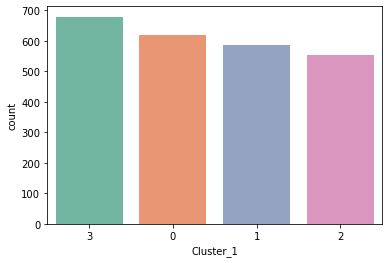

In [20]:
# Composición de los clusters formados
sns.countplot(x="Cluster_1",data=df_final, palette="Set2", order = df_final['Cluster_1'].value_counts().index)

In [22]:
# Composición de los clusters - Media de las variables por cluster
df_final.groupby(['Cluster_1']).mean()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction,PCA1,PCA2,PCA3
Cluster_1,,,,,,,,,,,,,,,,,,,,,
0,0.411955,0.798061,39.249175,0.633279,1.759289,1252.379538,2.615509,3.085622,2.854604,3.231018,...,2.512116,2.505654,2.660743,2.571890,3.344103,12.014851,0.156704,1.134978,-0.409540,-1.983693
1,0.545299,0.694017,39.367133,0.524786,1.579487,1158.482517,2.340171,3.124786,2.471795,2.981197,...,3.189744,3.664957,3.169231,3.758974,1.765812,10.445804,0.129915,2.807318,-0.779813,1.497115
2,0.510830,0.857401,40.373383,0.839350,2.384477,1189.445471,1.796029,1.781588,1.590253,1.915162,...,3.734657,4.079422,3.568592,4.097473,3.938628,10.722736,0.669675,-0.895030,2.742487,0.307954
3,0.500736,0.893962,39.176829,0.780560,2.400589,1243.285061,3.948454,4.042710,3.899853,3.721649,...,3.930781,4.209131,3.643594,4.234168,3.910162,10.626524,0.740795,-2.723101,-1.192404,0.267286


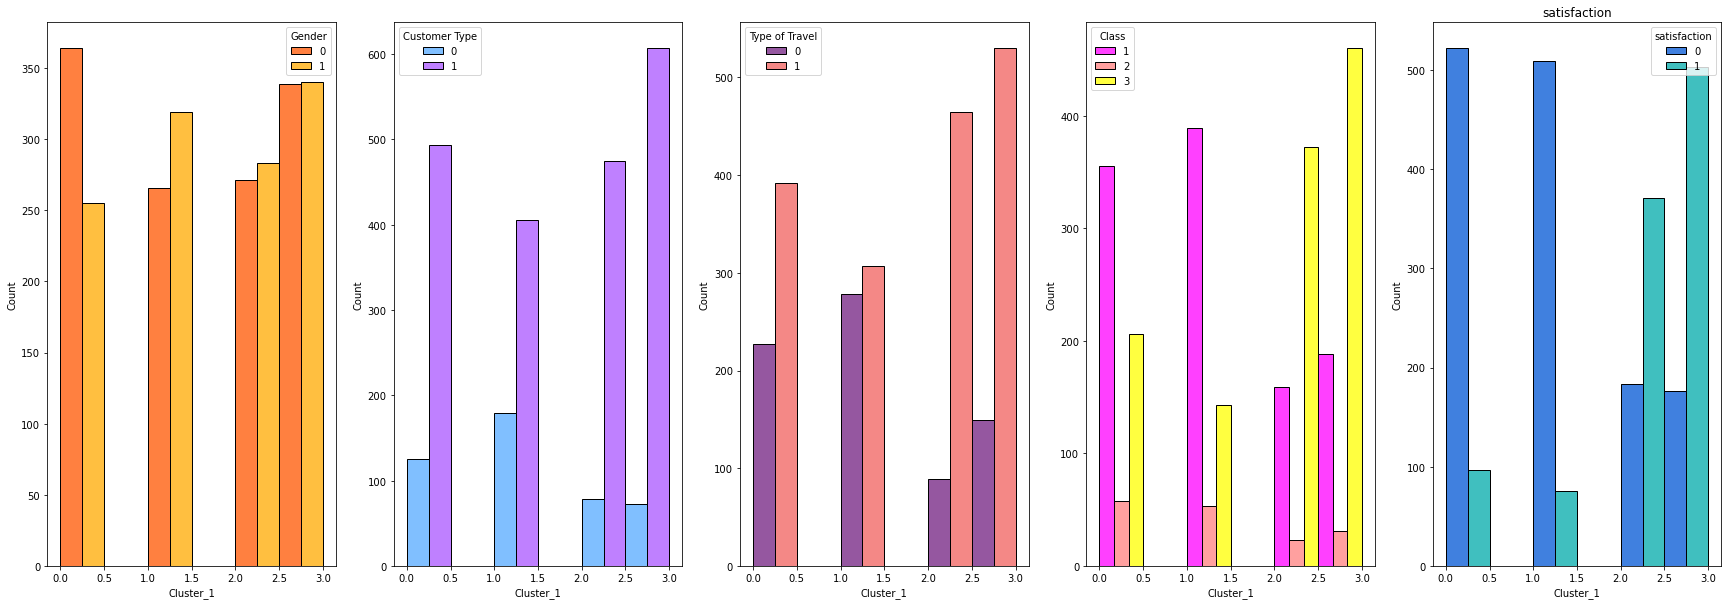

In [24]:
# Variables Categóricas
df_final['Cluster_1']= df_final['Cluster_1'].astype('int')
cat_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'satisfaction']

pal=['autumn','cool','magma','spring','winter'] # 5 color palettes for 5 categorical vars
    
fig,axs=plt.subplots(ncols=5,figsize =(30, 10))

for idx,i in enumerate(df_final[cat_cols].columns):
    plt.title(i)
    sns.histplot(data=df_final,x='Cluster_1', hue=i, palette=pal[idx], binwidth=.5, ax=axs[idx] ,multiple='dodge')

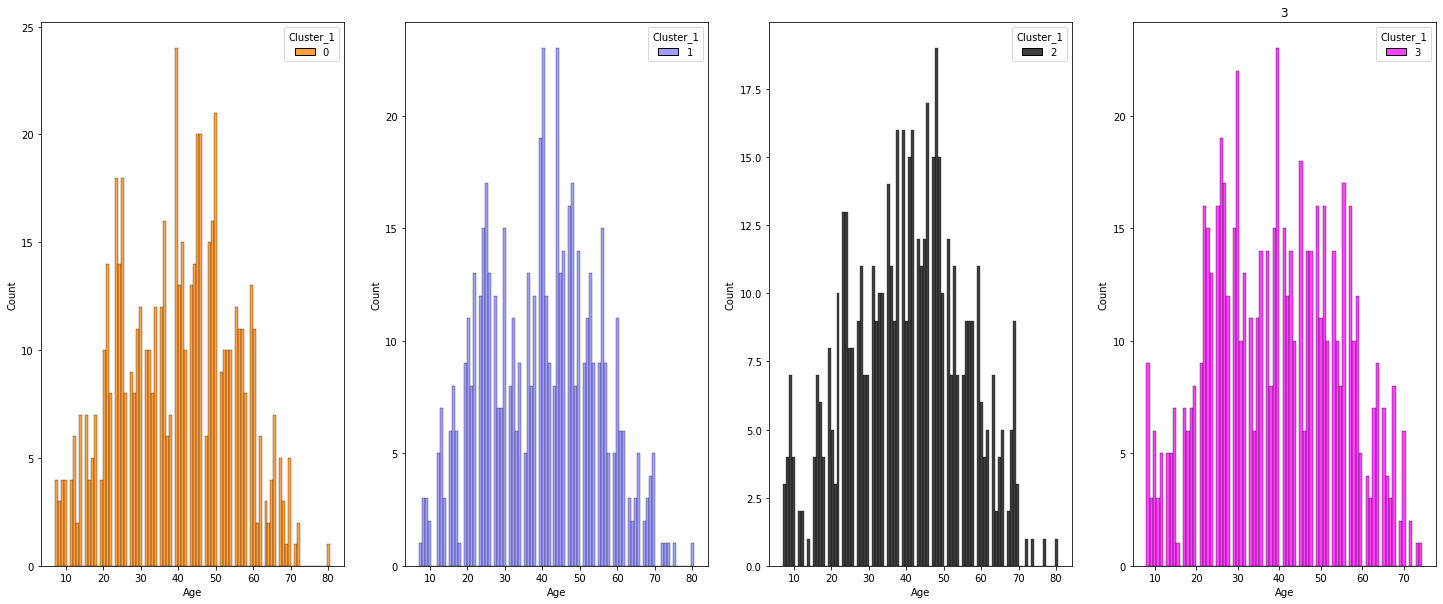

In [25]:
# Análisis de la edad
temp_edad = df_final[['Cluster_1','Age']]
fig,axs=plt.subplots(ncols=4,figsize =(25, 10))

for i in list(range(0,4)):
    plt.title(i)
    sns.histplot(data=temp_edad[temp_edad.Cluster_1==i],x='Age',hue='Cluster_1',palette=pal[i],binwidth=.8,ax=axs[i],multiple='dodge')

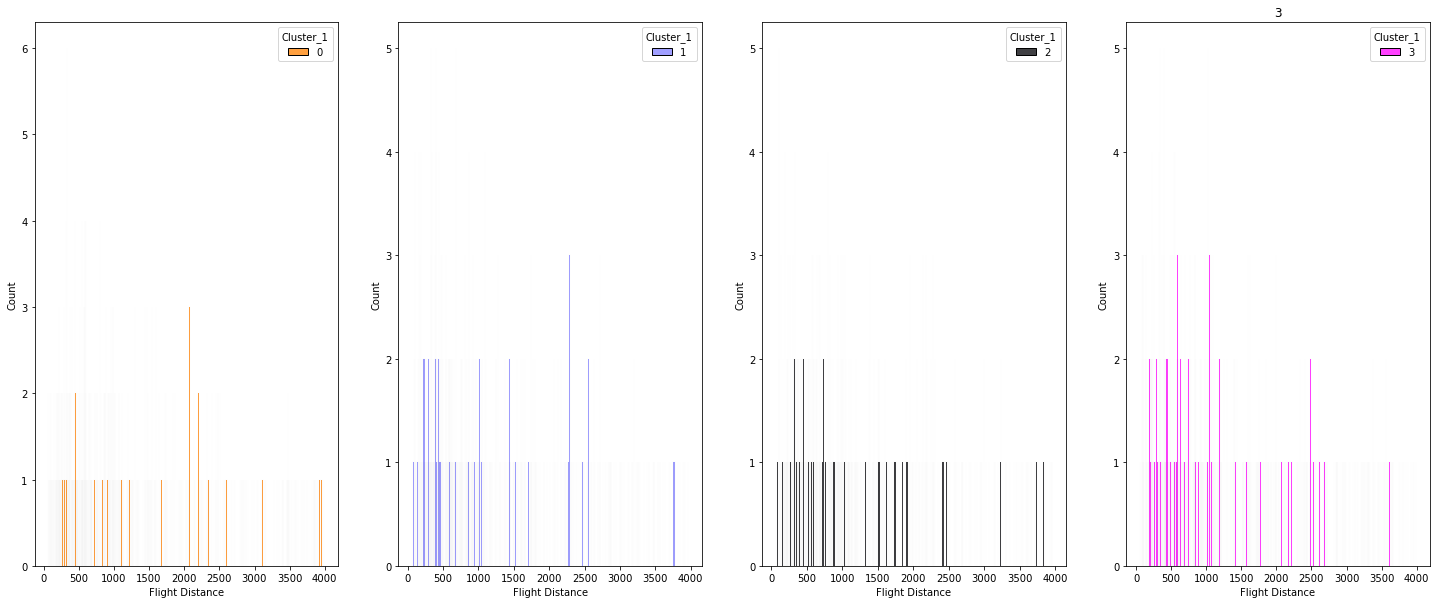

In [26]:
# Análisis de la distancia recorrida
temp_distancia = df_final[['Cluster_1','Flight Distance']]
fig,axs=plt.subplots(ncols=4,figsize =(25, 10))

for i in list(range(0,4)):
    plt.title(i)
    sns.histplot(data=temp_distancia[temp_distancia.Cluster_1==i],x='Flight Distance',hue='Cluster_1',palette=pal[i],binwidth=.8,ax=axs[i],multiple='dodge')

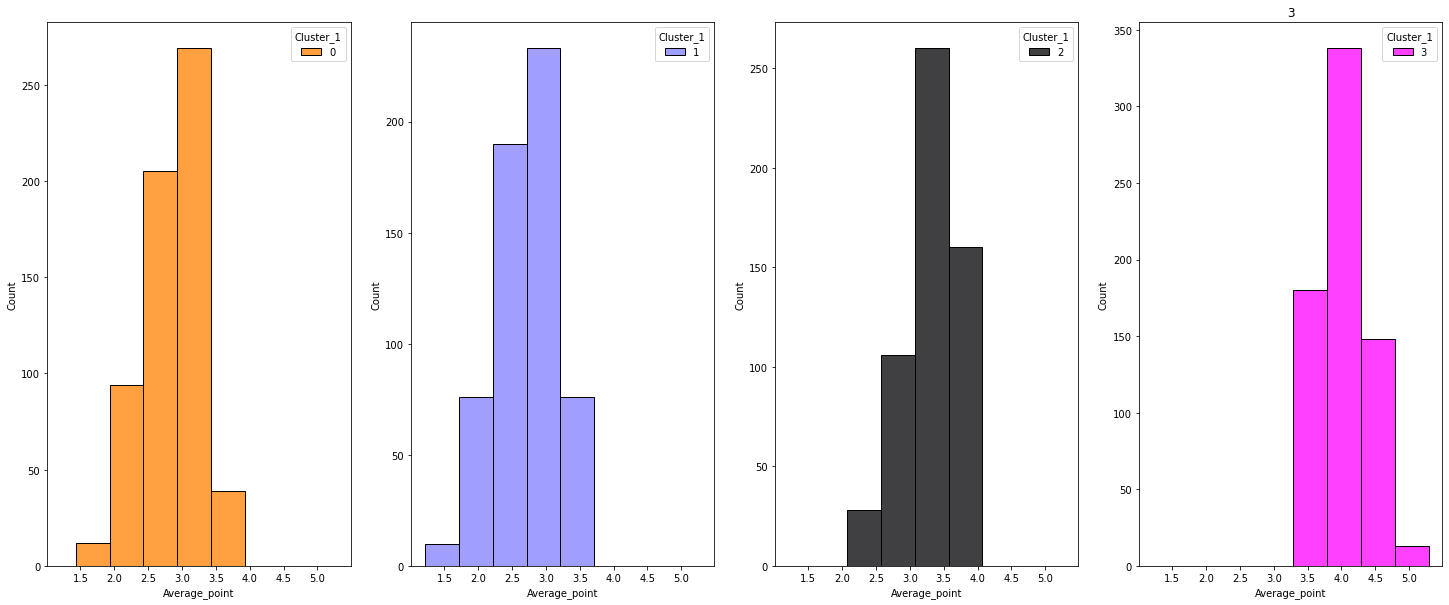

In [27]:
# Analisis de la encuesta
temp_encuesta = df_final.columns[6:20]
df_final["Average_point"]=round(df_final[temp_encuesta].mean(axis=1),3)

fig,axs=plt.subplots(ncols=4,figsize =(25, 10),sharex=True)

for i in list(range(0,4)):
    plt.title(i)
    sns.histplot(data=df_final[df_final.Cluster_1==i],x="Average_point",hue="Cluster_1",palette=pal[i],binwidth=.5,ax=axs[i],multiple='dodge')

In [29]:
df_final[df_final['Cluster_1']==3]['Customer Type'].value_counts(normalize=True)

1    0.893962
0    0.106038
Name: Customer Type, dtype: float64

###  Summary

**Cluster 0**
* Mayor proporcion de hombres que de mujeres
* La mayoría  de clientes son leales, pero en comparación con los otros cluster tiene mayor proporción de clientes desleales (29,3%).
* Proporción significativa de "viajes personales" (45,7%)
* Los asientos "Eco" representan el 66% de las reservas; los "Eco Plus" son los menos reservados
* La mayor proporción de pasajeros jóvenes (~20 años); la proporción de pasajeros de más edad disminuye constantemente hasta los mayores de 70 años
* Los pasajeros tienden a dar puntos de valoración bajos, con más frecuencia entre "2,5" y "3"; mientras que "4,0" suele ser la máxima
* las distancias de los vuelos aéreos no suelen superar las 2000 millas,  menos  viajes de larga distancia.
* Solo el 15% de los clientes estan satisfechos (peor resultado)


**Cluster 1**


**Cluster 2**


**Cluster 3**



## Análisis de  factores

### Prueba de adecuación

La prueba de esfericidad de Bartlett verifica si las variables observadas se intercorrelacionan o no utilizando la matriz de correlación observada contra la matriz de identidad. Si la prueba resulta estadísticamente insignificante, no se debe emplear un análisis factorial.

En esta prueba de Bartlett, el valor p es 0. La prueba fue estadísticamente significativa, lo que indica que la matriz de correlación observada no es una matriz de identidad.

In [30]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

# Selección de variables de encuestas
df_fa = train_df1_out[train_df1_out.columns[6:20]] 

# Aplicación de la prueba bartlett_sphericity
chi_square_value, p_value = calculate_bartlett_sphericity(df_fa)
chi_square_value, p_value

(14366.958751980415, 0.0)

La prueba KMO mide la idoneidad de los datos para el análisis factorial. Determina la adecuación para cada variable observada y para el modelo completo. KMO estima la proporción de varianza entre todas las variables observadas. Una proporción más baja es más adecuada para el análisis factorial. Los valores de KMO oscilan entre 0 y 1. Un valor de KMO inferior a 0,6 se considera inadecuado.

El KMO general de nuestros datos es 0.78, lo cual es excelente. Este valor indica que puede continuar con el análisis factorial planificado.

In [31]:
from factor_analyzer.factor_analyzer import calculate_kmo

# Aplicación de la prueba KMO
kmo_all,kmo_model=calculate_kmo(df_fa)
kmo_model

0.77719305118449

### Elección del número de factores

In [32]:
# Crear un objeto de análisis factorial y realizar un análisis factorial
fa = FactorAnalyzer(15, rotation=None)
fa.fit(df_fa)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([3.7872131 , 2.42047051, 2.15222616, 1.05246734, 0.95912402,
       0.72853   , 0.53529819, 0.48520748, 0.45096344, 0.38345836,
       0.32998234, 0.304345  , 0.23320468, 0.17750936])

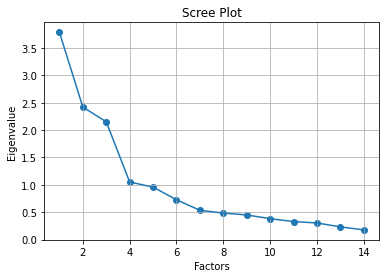

In [33]:
# Diagrama con valores propios
plt.scatter(range(1,df_fa.shape[1]+1),ev)
plt.plot(range(1,df_fa.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

Aquí sólo utilizaremos 3 factores, dada la gran caída del valor propio después del tercer factor. Veamos qué factores se crean y qué variables contienen.

### Aplicación de análisis factorial

In [34]:
# Analisis factorial
fa = FactorAnalyzer(3, rotation='varimax')
fa.fit(df_fa)

# Cargas
loads = fa.loadings_

# Cargas por cada variable y factor
print(pd.DataFrame(fa.loadings_,index=df_fa.columns))

                                          0         1         2
Inflight wifi service              0.169749  0.140741  0.759046
Departure/Arrival time convenient -0.034306  0.064488  0.556712
Ease of Online booking             0.045098  0.015996  0.940801
Gate location                     -0.031787 -0.073832  0.513856
Food and drink                     0.753372 -0.030740  0.004576
Online boarding                    0.400067  0.166991  0.328788
Seat comfort                       0.765813  0.113887  0.019703
Inflight entertainment             0.773256  0.446225  0.008594
On-board service                   0.096142  0.725267  0.006432
Leg room service                   0.101180  0.437230  0.088727
Baggage handling                   0.025002  0.753213  0.029692
Checkin service                    0.090761  0.298286  0.003882
Inflight service                   0.018654  0.793705  0.010756
Cleanliness                        0.850838  0.080768  0.002498


He aquí los 3 factores, las variables que contienen y su posible "interpretabilidad":

* Comodidad: Comida y bebida, Comodidad del asiento, Entretenimiento a bordo, Limpieza

* Servicio: Servicio a bordo, Gestión de equipajes, Servicio a bordo

* Conveniencia: Wifi en vuelo, Comodidad de la hora de salida/llegada, Reserva en línea, Ubicación de la puerta de embarque.

In [35]:
# Varianza explicada por cada factor
print(pd.DataFrame(fa.get_factor_variance(),index=['Variance','Proportional Var','Cumulative Var']))

                         0         1         2
Variance          2.697671  2.280571  2.152752
Proportional Var  0.192691  0.162898  0.153768
Cumulative Var    0.192691  0.355589  0.509357


In [36]:
# Análisis de comunalidad
print(pd.DataFrame(fa.get_communalities(),index=df_fa.columns,columns=['Communalities']))

                                   Communalities
Inflight wifi service                   0.624774
Departure/Arrival time convenient       0.315264
Ease of Online booking                  0.887397
Gate location                           0.270510
Food and drink                          0.568535
Online boarding                         0.296041
Seat comfort                            0.599829
Inflight entertainment                  0.797115
On-board service                        0.535296
Leg room service                        0.209280
Baggage handling                        0.568837
Checkin service                         0.097227
Inflight service                        0.630431
Cleanliness                             0.730456


In [37]:
# Transformación del dataset
X_fa = fa.fit_transform(df_fa)
X_fa.shape

(2437, 3)

In [38]:
X_fa

array([[ 0.48309787,  0.47126524, -0.71994073],
       [ 0.27154921, -1.55625754, -1.28173859],
       [-1.17586572, -0.07145068, -0.46042441],
       ...,
       [ 0.28652243,  1.04134296,  0.06449807],
       [ 0.68883984, -0.59533962,  0.10235632],
       [-0.22419221, -0.22071258,  0.12025768]])